In [41]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [42]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\akhil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
def load_doc(jsonFile):
    with open(jsonFile) as file:
        Json_data = json.loads(file.read())
    return Json_data

data = load_doc('./new_intents.json')
data

{'intents': [{'tag': 'start_conversation',
   'patterns': ['Hi there', 'Is anyone there?', 'Hey', 'Hola', 'Hello', 'Hi'],
   'responses': ['Hello',
    'Happy to have you here',
    'Good to see you again',
    'Hi there, how can I help?'],
   'context': ['']},
  {'tag': 'what_are_you',
   'patterns': ['What is your name?',
    'what are you?',
    'who are you?',
    'your name pls?'],
   'responses': ["Hi, I'm  Bowhead Bot",
    "I'm Bowhead Bot ",
    'Call me Bowhead Bot'],
   'context': ['']},
  {'tag': 'end_conversation',
   'patterns': ['Bye',
    'See you later',
    'Good bye',
    'Goodbye',
    'Nice chatting with you, bye'],
   'responses': ['Have a lovely Day!', 'Bye', 'Happy to help you'],
   'context': ['']},
  {'tag': 'thanks',
   'patterns': ['Thanks',
    'Thank you',
    'That is helpful',
    'Awesome, thanks',
    'Thanks for helping me'],
   'responses': ['Happy to help!', 'Any time!'],
   'context': ['']},
  {'tag': 'not_satisfied',
   'patterns': ['That is not h

In [44]:
def frame_data(feat_1,feat_2,is_pattern):
    is_pattern = is_pattern
    df = pd.DataFrame(columns=[feat_1,feat_2])
    for intent in data['intents']:
        if is_pattern:
            for pattern in intent['patterns']:
                w = pattern
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
        else:
            for response in intent['responses']:
                w = response
                df_to_append = pd.Series([w,intent['tag']], index = df.columns)
                df = df.append(df_to_append,ignore_index=True)
    return df

In [45]:
questions_df = frame_data('questions','labels',True)
questions_df

,questions,labels
0,Hi there,start_conversation
1,Is anyone there?,start_conversation
2,Hey,start_conversation
3,Hola,start_conversation
4,Hello,start_conversation
5,Hi,start_conversation
6,What is your name?,what_are_you
7,what are you?,what_are_you
8,who are you?,what_are_you
9,your name pls?,what_are_you


In [46]:
responses_df = frame_data('responses','labels',False)
responses_df

,responses,labels
0,Hello,start_conversation
1,Happy to have you here,start_conversation
2,Good to see you again,start_conversation
3,"Hi there, how can I help?",start_conversation
4,"Hi, I'm Bowhead Bot",what_are_you
5,I'm Bowhead Bot,what_are_you
6,Call me Bowhead Bot,what_are_you
7,Have a lovely Day!,end_conversation
8,Bye,end_conversation
9,Happy to help you,end_conversation


# For creating tokens and vocab of training data;this vocab is later used when testing new user input(testing the bot)

In [47]:
lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    print(tokens)
    return tokens

def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,'tokens_v4.pkl')
        doc_without_stopwords.append(' '.join(tokens))
        print(doc_without_stopwords)
    df[feature] = doc_without_stopwords
    return 

def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)   
        vocab.update(tokens)
        print(vocab)
    joblib.dump(vocab,'vocab_v4.pkl')
    return 


create_vocab(tokenizer,questions_df,'questions')
remove_stop_words(tokenizer,questions_df,'questions')

['hi', 'there']
Counter({'hi': 1, 'there': 1})
['is', 'anyone', 'there']
Counter({'there': 2, 'hi': 1, 'is': 1, 'anyone': 1})
['hey']
Counter({'there': 2, 'hi': 1, 'is': 1, 'anyone': 1, 'hey': 1})
['hola']
Counter({'there': 2, 'hi': 1, 'is': 1, 'anyone': 1, 'hey': 1, 'hola': 1})
['hello']
Counter({'there': 2, 'hi': 1, 'is': 1, 'anyone': 1, 'hey': 1, 'hola': 1, 'hello': 1})
['hi']
Counter({'hi': 2, 'there': 2, 'is': 1, 'anyone': 1, 'hey': 1, 'hola': 1, 'hello': 1})
['what', 'is', 'your', 'name']
Counter({'hi': 2, 'there': 2, 'is': 2, 'anyone': 1, 'hey': 1, 'hola': 1, 'hello': 1, 'what': 1, 'your': 1, 'name': 1})
['what', 'are', 'you']
Counter({'hi': 2, 'there': 2, 'is': 2, 'what': 2, 'anyone': 1, 'hey': 1, 'hola': 1, 'hello': 1, 'your': 1, 'name': 1, 'are': 1, 'you': 1})
['who', 'are', 'you']
Counter({'hi': 2, 'there': 2, 'is': 2, 'what': 2, 'are': 2, 'you': 2, 'anyone': 1, 'hey': 1, 'hola': 1, 'hello': 1, 'your': 1, 'name': 1, 'who': 1})
['your', 'name', 'pls']
Counter({'hi': 2, 'there

['hi there', 'is anyone there', 'hey']
['hola']
['hi there', 'is anyone there', 'hey', 'hola']
['hello']
['hi there', 'is anyone there', 'hey', 'hola', 'hello']
['hi']
['hi there', 'is anyone there', 'hey', 'hola', 'hello', 'hi']
['what', 'is', 'your', 'name']
['hi there', 'is anyone there', 'hey', 'hola', 'hello', 'hi', 'what is your name']
['what', 'are', 'you']
['hi there', 'is anyone there', 'hey', 'hola', 'hello', 'hi', 'what is your name', 'what are you']
['who', 'are', 'you']
['hi there', 'is anyone there', 'hey', 'hola', 'hello', 'hi', 'what is your name', 'what are you', 'who are you']
['your', 'name', 'pls']
['hi there', 'is anyone there', 'hey', 'hola', 'hello', 'hi', 'what is your name', 'what are you', 'who are you', 'your name pls']
['bye']
['hi there', 'is anyone there', 'hey', 'hola', 'hello', 'hi', 'what is your name', 'what are you', 'who are you', 'your name pls', 'bye']
['see', 'you', 'later']
['hi there', 'is anyone there', 'hey', 'hola', 'hello', 'hi', 'what is yo

['hi there', 'is anyone there', 'hey', 'hola', 'hello', 'hi', 'what is your name', 'what are you', 'who are you', 'your name pls', 'bye', 'see you later', 'good bye', 'goodbye', 'nice chatting with you bye', 'thanks', 'thank you', 'that is helpful', 'awesome thanks', 'thanks for helping me', 'that is not helpful', 'you dont understand', 'that is not what want', 'it is not what asked for', 'you are bad', 'you do not seem to be of much help', 'you are not helpful', 'how can you help me', 'what can you do', 'what service do you provide', 'which service', 'what service', 'what other service do you offer', 'tell me few service', 'how can you help other than trial', 'what can you tell me about covid trial', 'need some information about covid trial', 'covid trial information needed', 'want to know about covid trial', 'show me covid trial info', 'want to find hepatitis trial', 'find heart trial detail', 'find medical trial info', 'diabetes trial', 'find study for breast trial', 'want to find s

# Creating training and test data and storing the indexes

In [48]:
# Creating a test list containing only the first question of each group after grouping them according to their labels.
test_list = list(questions_df.groupby(by='labels',as_index=False).first()['questions'])
test_list

# The index of the above test observations taken from the dataframe df1
test_index = []
for i,_ in enumerate(test_list):
    idx = questions_df[questions_df.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index

# Train index
train_index = [i for i in questions_df.index if i not in test_index]
train_index

['bye',
 'that is not helpful',
 'how can you help me',
 'what service do you provide',
 'hi there',
 'can you help me find survey',
 'thanks',
 'what can you tell me about covid trial',
 'what is your name']

[10, 20, 27, 29, 0, 47, 15, 35, 6]

[1,
 2,
 3,
 4,
 5,
 7,
 8,
 9,
 11,
 12,
 13,
 14,
 16,
 17,
 18,
 19,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56]

# Initializing a tokenizer, fitting it on to questions df and encoding the questions_df

In [49]:
def encoder(df,feature):
#     text = ' '.join(list(vocab.keys()))
#     from tensorflow.keras.preprocessing.text import text_to_word_sequence
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    print(entries)
    #step1 To create dictionary having 'keys' as words from each entry(sentences) and 'values' are randomly assigned by tokenizer.
    t.fit_on_texts(entries)
    print(t.word_index)
    joblib.dump(t,'tokenizer_t_v4.pkl')
    vocab_size = len(t.word_index) + 1
    print(vocab_size)
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    print(max_length)
    #setp2 To see the output of the dataframe when dictionary 'values' from the above created dictionary in step1 are used in the place of the words in the sentences
    encoded = t.texts_to_sequences(entries)
    print(encoded)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded, vocab_size

In [50]:
X,vocab_size = encoder(questions_df,'questions')
X
questions_df_encoded = pd.DataFrame(X)
questions_df_encoded['labels'] = questions_df.labels
questions_df_encoded

['hi there', 'is anyone there', 'hey', 'hola', 'hello', 'hi', 'what is your name', 'what are you', 'who are you', 'your name pls', 'bye', 'see you later', 'good bye', 'goodbye', 'nice chatting with you bye', 'thanks', 'thank you', 'that is helpful', 'awesome thanks', 'thanks for helping me', 'that is not helpful', 'you dont understand', 'that is not what want', 'it is not what asked for', 'you are bad', 'you do not seem to be of much help', 'you are not helpful', 'how can you help me', 'what can you do', 'what service do you provide', 'which service', 'what service', 'what other service do you offer', 'tell me few service', 'how can you help other than trial', 'what can you tell me about covid trial', 'need some information about covid trial', 'covid trial information needed', 'want to know about covid trial', 'show me covid trial info', 'want to find hepatitis trial', 'find heart trial detail', 'find medical trial info', 'diabetes trial', 'find study for breast trial', 'want to find s

array([[25, 26,  0,  0,  0,  0,  0,  0,  0],
       [ 8, 38, 26,  0,  0,  0,  0,  0,  0],
       [39,  0,  0,  0,  0,  0,  0,  0,  0],
       [40,  0,  0,  0,  0,  0,  0,  0,  0],
       [41,  0,  0,  0,  0,  0,  0,  0,  0],
       [25,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  8, 27, 28,  0,  0,  0,  0,  0],
       [ 5, 16,  1,  0,  0,  0,  0,  0,  0],
       [42, 16,  1,  0,  0,  0,  0,  0,  0],
       [27, 28, 43,  0,  0,  0,  0,  0,  0],
       [19,  0,  0,  0,  0,  0,  0,  0,  0],
       [44,  1, 45,  0,  0,  0,  0,  0,  0],
       [46, 19,  0,  0,  0,  0,  0,  0,  0],
       [47,  0,  0,  0,  0,  0,  0,  0,  0],
       [48, 49, 50,  1, 19,  0,  0,  0,  0],
       [20,  0,  0,  0,  0,  0,  0,  0,  0],
       [51,  1,  0,  0,  0,  0,  0,  0,  0],
       [21,  8, 22,  0,  0,  0,  0,  0,  0],
       [52, 20,  0,  0,  0,  0,  0,  0,  0],
       [20, 17, 53,  3,  0,  0,  0,  0,  0],
       [21,  8, 10, 22,  0,  0,  0,  0,  0],
       [ 1, 54, 55,  0,  0,  0,  0,  0,  0],
       [21

,0,1,2,3,4,5,6,7,8,labels
0,25,26,0,0,0,0,0,0,0,start_conversation
1,8,38,26,0,0,0,0,0,0,start_conversation
2,39,0,0,0,0,0,0,0,0,start_conversation
3,40,0,0,0,0,0,0,0,0,start_conversation
4,41,0,0,0,0,0,0,0,0,start_conversation
5,25,0,0,0,0,0,0,0,0,start_conversation
6,5,8,27,28,0,0,0,0,0,what_are_you
7,5,16,1,0,0,0,0,0,0,what_are_you
8,42,16,1,0,0,0,0,0,0,what_are_you
9,27,28,43,0,0,0,0,0,0,what_are_you


In [51]:
#Creating 2 observations with 'confused' label and appending them to dataframe.
#max_length should be used to create to observations with arrays of max_length size
for i in range(0,2):
    dt = [0]*9
    dt.append('confused')
    dt = [dt]
    pd.DataFrame(dt).rename(columns = {9:'labels'})
    questions_df_encoded = questions_df_encoded.append(pd.DataFrame(dt).rename(columns = {9:'labels'}),ignore_index=True)
    
questions_df_encoded

,0,1,2,3,4,5,6,7,8,labels
0,0,0,0,0,0,0,0,0,0,confused


,0,1,2,3,4,5,6,7,8,labels
0,0,0,0,0,0,0,0,0,0,confused


,0,1,2,3,4,5,6,7,8,labels
0,25,26,0,0,0,0,0,0,0,start_conversation
1,8,38,26,0,0,0,0,0,0,start_conversation
2,39,0,0,0,0,0,0,0,0,start_conversation
3,40,0,0,0,0,0,0,0,0,start_conversation
4,41,0,0,0,0,0,0,0,0,start_conversation
5,25,0,0,0,0,0,0,0,0,start_conversation
6,5,8,27,28,0,0,0,0,0,what_are_you
7,5,16,1,0,0,0,0,0,0,what_are_you
8,42,16,1,0,0,0,0,0,0,what_are_you
9,27,28,43,0,0,0,0,0,0,what_are_you


In [52]:
# Appending one of the confused labeled observation to train index by appending the correspoding index number
train_index.append(57)
# Appending one of the confused labeled observation to test index
test_index.append(58)

# Encoding the labels of questions_df_encoded and then later responses_df 

In [53]:
# Encoding the 'labels' with values choosen(random) by labelEncoder 
from sklearn.preprocessing import LabelEncoder
lable_enc = LabelEncoder()

labl = lable_enc.fit_transform(questions_df_encoded.labels)
labl

mapper = {}
for index,key in enumerate(questions_df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

array([5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0])

{'start_conversation': 5,
 'what_are_you': 9,
 'end_conversation': 1,
 'thanks': 7,
 'not_satisfied': 2,
 'options': 3,
 'services': 4,
 'trials': 8,
 'surveys': 6,
 'confused': 0}

In [54]:
# Encoding the labels of responses dataframe df2 with values choosen from questions dataframe df1.
responses_df.labels = responses_df.labels.map(mapper).astype({'labels': 'int32'})
responses_df
responses_df.to_csv('./responses.csv')

,responses,labels
0,Hello,5
1,Happy to have you here,5
2,Good to see you again,5
3,"Hi there, how can I help?",5
4,"Hi, I'm Bowhead Bot",9
5,I'm Bowhead Bot,9
6,Call me Bowhead Bot,9
7,Have a lovely Day!,1
8,Bye,1
9,Happy to help you,1


# Creating train and test for the model based on the above calculated indexes

In [238]:
train = questions_df_encoded.loc[train_index]
test = questions_df_encoded.loc[test_index]

# X_train = train.drop(columns=['labels'],axis=1)
# y_train = train.labels
# X_test = test.drop(columns=['labels'],axis=1)
# y_test = test.labels
# y_train =pd.get_dummies(y_train).values
# y_test =pd.get_dummies(y_test).values

# Creating training and testing and validation sets using test train split
X = questions_df_encoded.drop(columns=['labels'],axis=1)
y = questions_df_encoded.labels
y = pd.get_dummies(y).values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('X:',X.shape)
print('y:',y.shape)
print(X_train,y_train)

X: (59, 9)
y: (59, 10)
     0   1   2   3   4   5   6   7   8
22  21   8  10   5  11   0   0   0   0
48  11  12  74  75   6   0   0   0   0
54   7   1  13   3   2  18   6   0   0
55   2   3  18   6   0   0   0   0   0
2   39   0   0   0   0   0   0   0   0
1    8  38  26   0   0   0   0   0   0
25   1   9  10  59  12  60  61  62  13
8   42  16   1   0   0   0   0   0   0
34  29   7   1  13  30  66   4   0   0
40  11  12   2  69   4   0   0   0   0
28   5   7   1   9   0   0   0   0   0
11  44   1  45   0   0   0   0   0   0
37  15   4  33  68   0   0   0   0   0
53   5   6   9   1  31   0   0   0   0
3   40   0   0   0   0   0   0   0   0
16  51   1   0   0   0   0   0   0   0
39  35   3  15   4  36   0   0   0   0
4   41   0   0   0   0   0   0   0   0
10  19   0   0   0   0   0   0   0   0
52  77   6   0   0   0   0   0   0   0
18  52  20   0   0   0   0   0   0   0
47   7   1  13   3   2   6   0   0   0
31   5  14   0   0   0   0   0   0   0
13  47   0   0   0   0   0   0   0   0
30

In [239]:
X_train.shape, y_train.shape
X_test.shape,y_test.shape

((47, 9), (47, 10))

((12, 9), (12, 10))

In [240]:
max_length = X_train.shape[1]
max_length

#output should be max_length + 1 (This output is used in Dense layer)
output = 10

9

# Model construction

In [241]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
checkpoint = ModelCheckpoint("model-v4.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 10, verbose = 1, min_delta = 0.0001)
callbacks = [early_stopping,checkpoint,reduce_lr]


def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size,300, input_length=max_length))
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Flatten())
    model.add(Dense(output, activation='softmax'))
    # compile network
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # summarize defined model
    model.summary()
    return model

In [242]:
model = define_model(vocab_size, max_length)

Model: "sequential_1345"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1345 (Embedding)   (None, 9, 300)            23700     
_________________________________________________________________
conv1d_1343 (Conv1D)         (None, 6, 64)             76864     
_________________________________________________________________
max_pooling1d_569 (MaxPoolin (None, 1, 64)             0         
_________________________________________________________________
flatten_549 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_539 (Dense)            (None, 10)                650       
Total params: 101,214
Trainable params: 101,214
Non-trainable params: 0
_________________________________________________________________


In [243]:
history = model.fit(X_train, y_train, epochs=100, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

Train on 47 samples, validate on 12 samples
Epoch 1/100
32/47 [===================>..........] - ETA: 8s - loss: 2.3010 - acc: 0.0312
Epoch 00001: val_loss improved from inf to 2.29439, saving model to model-v4.h5
47/47 [==============================] - 169s 4s/sample - loss: 2.3094 - acc: 0.0213 - val_loss: 2.2944 - val_acc: 0.1667
Epoch 2/100
32/47 [===================>..........] - ETA: 0s - loss: 2.2164 - acc: 0.4688
Epoch 00002: val_loss improved from 2.29439 to 2.27428, saving model to model-v4.h5
47/47 [==============================] - 0s 9ms/sample - loss: 2.2132 - acc: 0.4468 - val_loss: 2.2743 - val_acc: 0.1667
Epoch 3/100
32/47 [===================>..........] - ETA: 0s - loss: 2.1538 - acc: 0.5312
Epoch 00003: val_loss improved from 2.27428 to 2.25569, saving model to model-v4.h5
47/47 [==============================] - 0s 9ms/sample - loss: 2.1457 - acc: 0.5532 - val_loss: 2.2557 - val_acc: 0.1667
Epoch 4/100
32/47 [===================>..........] - ETA: 0s - loss: 2.099

47/47 [==============================] - 0s 9ms/sample - loss: 0.4207 - acc: 1.0000 - val_loss: 1.6858 - val_acc: 0.6667
Epoch 29/100
32/47 [===================>..........] - ETA: 0s - loss: 0.4008 - acc: 1.0000
Epoch 00029: val_loss improved from 1.68580 to 1.65873, saving model to model-v4.h5
47/47 [==============================] - 0s 9ms/sample - loss: 0.3796 - acc: 1.0000 - val_loss: 1.6587 - val_acc: 0.6667
Epoch 30/100
32/47 [===================>..........] - ETA: 0s - loss: 0.3616 - acc: 1.0000
Epoch 00030: val_loss improved from 1.65873 to 1.63531, saving model to model-v4.h5
47/47 [==============================] - 0s 9ms/sample - loss: 0.3391 - acc: 1.0000 - val_loss: 1.6353 - val_acc: 0.6667
Epoch 31/100
32/47 [===================>..........] - ETA: 0s - loss: 0.2747 - acc: 1.0000
Epoch 00031: val_loss improved from 1.63531 to 1.61679, saving model to model-v4.h5
47/47 [==============================] - 0s 10ms/sample - loss: 0.2992 - acc: 1.0000 - val_loss: 1.6168 - val_ac

Train: 1.000, Test: 0.750


<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'Loss over Epochs')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

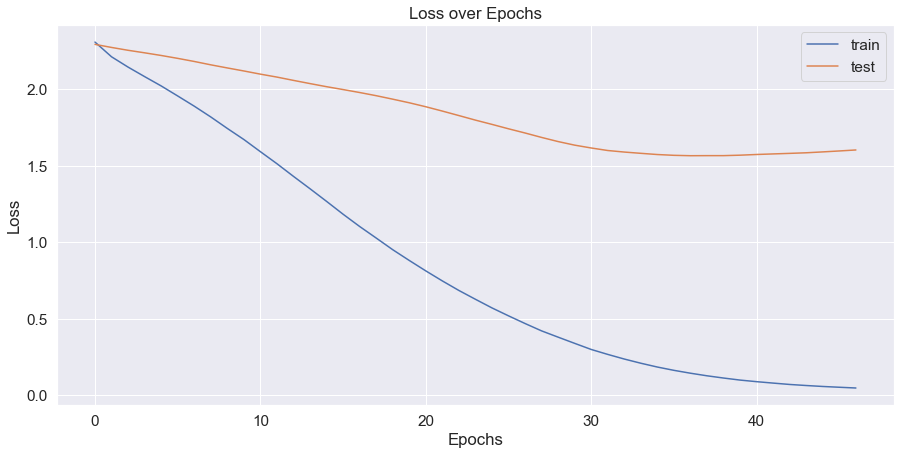

In [249]:
import matplotlib.pyplot as plt
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss during training
plt.figure(figsize=(15,7))
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'Accuracy over Epochs')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

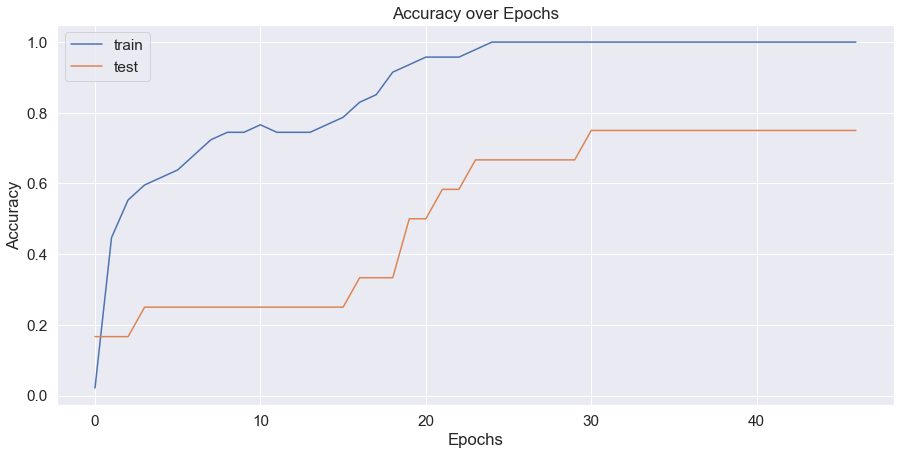

In [250]:
# plot accuracy during training
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [246]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
classifier_accuracy = accuracy_score(y_pred.argmax(axis=1),y_test.argmax(axis=1))
classifier_precision = precision_score(y_pred.argmax(axis=1),y_test.argmax(axis=1), average='weighted')
classifier_recall = recall_score(y_pred.argmax(axis=1),y_test.argmax(axis=1), average='weighted')
classifier_f1score = f1_score(y_pred.argmax(axis=1),y_test.argmax(axis=1), average='weighted')

metrics = {"Accuracy" : classifier_accuracy, "Precision" : classifier_precision, "Recall" : classifier_recall, "F1 score" : classifier_f1score}
print(metrics)

{'Accuracy': 0.75, 'Precision': 0.9166666666666666, 'Recall': 0.75, 'F1 score': 0.7916666666666666}


C:\Users\akhil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\akhil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

<AxesSubplot:title={'center':'Confusion Matrix'}>

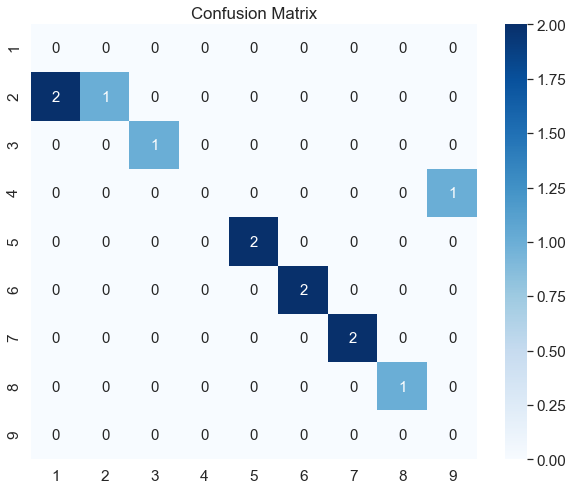

In [251]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

cm = confusion_matrix(y_pred.argmax(axis=1),y_test.argmax(axis=1))
cm_df = pd.DataFrame(cm, range(1,10),range(1,10))
plt.figure(figsize = (10,8))
plt.title('Confusion Matrix')
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_df,cmap=plt.cm.Blues,annot=True,annot_kws={"size": 15})

# Hyperparameter Tuning

In [61]:
## Hyperparameter tuning for the model

# import numpy
# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier

# def create_model(optimizer='adam', activation='relu', kernel_size=4, pool_size=4):
#     vocab_size = 79
#     max_length = 9
#     model = Sequential()
#     model.add(Embedding(vocab_size,300, input_length=max_length))
#     model.add(Conv1D(filters=64, kernel_size=kernel_size, activation=activation))
#     model.add(MaxPooling1D(pool_size=pool_size))
#     model.add(Flatten())
#     model.add(Dense(output, activation='softmax'))
#     # compile network
#     model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
#     # summarize defined model
#     return model

# seed = 7
# numpy.random.seed(seed)
# batch_size = 32
# epochs = 10

# model_CV = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=1)
# # define the grid search parameters
# # batches = [16, 32]
# # epochs = [25, 50]
# activation = ['relu', 'sigmoid', 'linear']
# optimizer = ['RMSprop','Adam', 'Adamax', 'Nadam']
# kernel_size = [4]
# pool_size = [4]


# # grid search for initializer, batch size and number of epochs
# param_grid = dict(activation=activation, optimizer=optimizer, kernel_size=kernel_size, pool_size=pool_size)
# grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, cv=10)
# grid_result = grid.fit(X_train, y_train)

# # print results
# print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print(f'mean={mean:.4}, std={stdev:.4} using {param}')
    

In [91]:
## Not possible because of static output shape. Cross validation will use different subsets of training at each run and 
## the max length of the strings in that subset may not be equal to the static output shape we set during defining
## model, which is a requirement.

# import numpy
# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_score


# def define_model():
#     vocab_size = 79
#     max_length =9
#     model = Sequential()
#     model.add(Embedding(vocab_size,300, input_length=max_length))
#     model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
#     model.add(MaxPooling1D(pool_size=4))
#     model.add(Flatten())
#     model.add(Dense(output, activation='softmax'))
#     # compile network
#     model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#     # summarize defined model
#     model.summary()
#     return model

# estimator = KerasClassifier(build_fn=define_model, epochs=100, batch_size=5,verbose=1)
# kfold = StratifiedKFold(n_splits=10, shuffle=True)
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# Testing the model

In [63]:
[np.argmax(i) for i in model.predict(X_test)][:8]

[1, 2, 6, 4, 5, 6, 7, 3]

In [64]:
[np.argmax(i) for i in y_test][:8]

[1, 2, 3, 4, 5, 6, 7, 8]

# Posing new question to our model

In [70]:
def get_text():
    input_text  = ['Hi']
    df_input = pd.DataFrame(input_text,columns=['questions'])
    print(df_input)
    a = df_input.iloc[0]['questions']
    print(type(a))
    if not a:
        print('true')
    return df_input 

#load artifacts 
from tensorflow.keras.models import load_model
model = load_model('model-v4.h5')
# tokenizer_t to be used in encode_input_text
tokenizer_t = joblib.load('tokenizer_t_v4.pkl')
# vocab to be used in bot_precaution
vocab = joblib.load('vocab_v4.pkl')

def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
#     stop_words = set(stopwords.words('english'))
#     tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df

def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=9, padding='post')
    return padded

def get_pred(model,encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    print(model.predict(encoded_input))
    return pred

def bot_precausion(df_input,pred):
    words = df_input.questions[0].split()
    if len([w for w in words if w in vocab])==0 :
        pred = 0
    return pred

def get_response(df2,pred):
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).responses)
    return responses[r]

def bot_response(response,):
    print(response)
    

In [71]:
df_input = get_text()

#load artifacts 
tokenizer_t = joblib.load('tokenizer_t_v4.pkl')
vocab = joblib.load('vocab_v4.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
input = df_input.iloc[0]['questions']
input
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')
encoded_input

pred = get_pred(model,encoded_input)
pred
pred = bot_precausion(df_input,pred)
pred

response = get_response(responses_df,pred)
bot_response(response)


  questions
0        Hi
<class 'str'>


'hi'

array([[25,  0,  0,  0,  0,  0,  0,  0,  0]])

[[1.2892806e-03 8.8563480e-04 1.2573725e-04 3.6857257e-04 6.2693434e-04
  9.9366051e-01 7.5435796e-04 1.0152556e-03 1.0995802e-03 1.7415948e-04]]


5

5

Good to see you again


# If we change intents.json, we need to make few modifications to this file.
# 1. In cell 46, change the indexes for appending confused labels accordingly.
# 2. In cell 56 of model construction, change the number of output nodes in Dense layer to match with the 'maxlength + 1' (If not already matched)
# And also change maxlen in encode_input_text in testing and in preprocessor.py file.
# Change model name in load_model testing when posing new question